In [1]:
import matplotlib
import numpy as np
import os
import sys
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
import pandas as pd
from scipy.interpolate import griddata, RegularGridInterpolator
from webbpsf.roman import FieldDependentAberration, RomanInstrument

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs

In [2]:
import mejiro

module_path = os.path.dirname(mejiro.__file__)
zernike_csv_path = os.path.join(module_path, 'data', 'wim_zernikes_cycle9.csv')

df = pd.read_csv(zernike_csv_path)
df

,sca,wavelength,field_point,local_x,local_y,global_x,global_y,axis_local_angle_x,axis_local_angle_y,wfe_rms_waves,...,Z13,Z14,Z15,Z16,Z17,Z18,Z19,Z20,Z21,Z22
0,1,0.48,1,0.059279,0.306887,-22.08070,12.45690,-0.06784,-0.03653,0.082,...,-0.002789,0.004603,0.001843,-0.004078,-0.006963,-0.005696,0.009127,0.005502,-0.009468,0.004253
1,1,0.48,2,-20.357900,20.729800,-42.49790,32.87980,-0.13072,-0.09842,0.073,...,-0.002919,0.006831,0.002134,-0.004824,-0.007530,-0.005435,0.010696,0.005947,-0.009230,0.002633
2,1,0.48,3,-20.370800,-20.112400,-42.51080,-7.96244,-0.13003,0.02435,0.103,...,-0.004100,0.003772,0.004853,-0.003967,-0.007755,-0.006832,0.010724,0.006372,-0.009132,0.002426
3,1,0.48,4,20.476500,-20.110000,-1.66348,-7.96002,-0.00520,0.02475,0.105,...,-0.003559,0.004706,0.003700,-0.002976,-0.007248,-0.006777,0.011311,0.003943,-0.009431,0.002786
4,1,0.48,5,20.488600,20.726400,-1.65143,32.87640,-0.00522,-0.09810,0.088,...,-0.002107,0.004780,0.004188,-0.005424,-0.007017,-0.007062,0.010042,0.005453,-0.008719,0.001534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1885,18,2.30,1,-0.076102,0.379944,112.56400,-50.68010,0.34003,0.14753,0.030,...,0.000561,0.001130,0.000900,-0.000359,-0.001537,-0.001501,0.002016,0.001284,-0.001787,0.000414
1886,18,2.30,2,-20.489100,20.794700,92.15090,-30.26530,0.27979,0.08886,0.033,...,-0.000147,0.001505,0.000291,0.000047,-0.001298,-0.001331,0.002123,0.001333,-0.001734,0.000916
1887,18,2.30,3,-20.502400,-20.037100,92.13760,-71.09710,0.27776,0.20780,0.027,...,-0.000081,0.000965,0.000606,-0.000390,-0.001421,-0.001673,0.001876,0.001386,-0.001689,0.000314
1888,18,2.30,4,20.337500,-20.029200,132.97800,-71.08920,0.39939,0.20514,0.030,...,0.000568,0.001557,0.001396,0.000107,-0.001153,-0.001883,0.002227,0.001191,-0.002008,0.000496


In [3]:
# get points for first SCA
sca1 = df[df['sca'] == 1]
sca1 = sca1[sca1['wavelength'] == 0.48]
sca1

,sca,wavelength,field_point,local_x,local_y,global_x,global_y,axis_local_angle_x,axis_local_angle_y,wfe_rms_waves,...,Z13,Z14,Z15,Z16,Z17,Z18,Z19,Z20,Z21,Z22
0,1,0.48,1,0.059279,0.306887,-22.08070,12.45690,-0.06784,-0.03653,0.082,...,-0.002789,0.004603,0.001843,-0.004078,-0.006963,-0.005696,0.009127,0.005502,-0.009468,0.004253
1,1,0.48,2,-20.357900,20.729800,-42.49790,32.87980,-0.13072,-0.09842,0.073,...,-0.002919,0.006831,0.002134,-0.004824,-0.007530,-0.005435,0.010696,0.005947,-0.009230,0.002633
2,1,0.48,3,-20.370800,-20.112400,-42.51080,-7.96244,-0.13003,0.02435,0.103,...,-0.004100,0.003772,0.004853,-0.003967,-0.007755,-0.006832,0.010724,0.006372,-0.009132,0.002426
3,1,0.48,4,20.476500,-20.110000,-1.66348,-7.96002,-0.00520,0.02475,0.105,...,-0.003559,0.004706,0.003700,-0.002976,-0.007248,-0.006777,0.011311,0.003943,-0.009431,0.002786
4,1,0.48,5,20.488600,20.726400,-1.65143,32.87640,-0.00522,-0.09810,0.088,...,-0.002107,0.004780,0.004188,-0.005424,-0.007017,-0.007062,0.010042,0.005453,-0.008719,0.001534


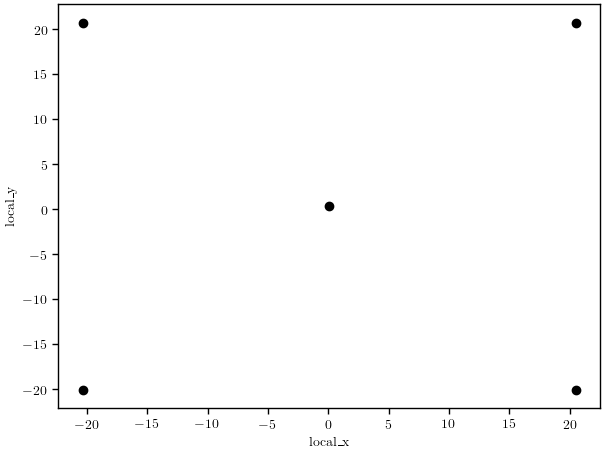

In [4]:
for index, row in sca1.iterrows():
    plt.plot(row['local_x'], row['local_y'], 'o', color='black')
plt.xlabel('local_x')
plt.ylabel('local_y')
plt.show()

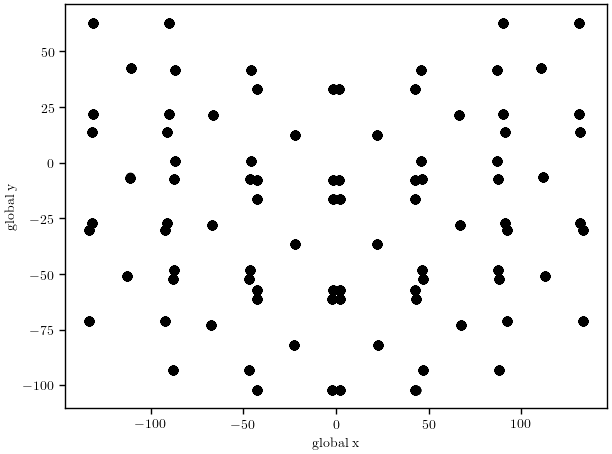

In [5]:
for index, row in df.iterrows():
    plt.plot(row['global_x'], row['global_y'], 'o', color='black')
plt.xlabel('global x')
plt.ylabel('global y')
plt.show()

In [6]:
points, values = [], []
for index, row in sca1.iterrows():
    points.append([row['local_x'], row['local_y']])
    values.append(row['Z4'])

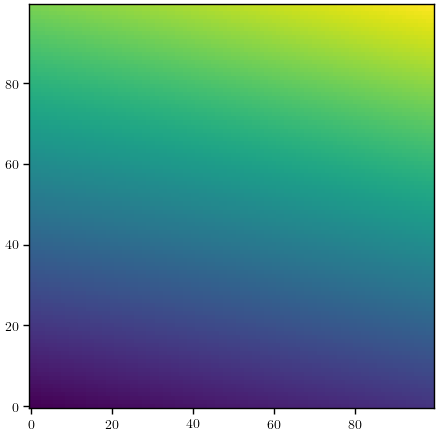

In [7]:
x = np.linspace(-20, 20, 100)
y = np.linspace(-20, 20, 100)
X, Y = np.meshgrid(x, y)

grid_z = griddata(points, values, (X, Y), method='cubic')

plt.imshow(grid_z)
plt.show()

In [8]:
arrays = []

# x = np.linspace(-22.5, 22.5, 100)
# y =  np.linspace(-22.5, 22.5, 100)
x = np.linspace(-20, 20, 100)
y = np.linspace(-20, 20, 100)
X, Y = np.meshgrid(x, y)

for sca in range(18):
    df = pd.read_csv(zernike_csv_path)
    sca += 1

    df = df[df['sca'] == sca]
    df = df[df['wavelength'] == 0.48]  # 1.06

    points, values = [], []
    for index, row in df.iterrows():
        points.append([row['local_x'], row['local_y']])
        values.append(row['Z4'])

    grid_z = griddata(points, values, (X, Y), method='cubic')
    grid_z = np.flipud(grid_z)
    # grid_z = util.center_crop_image(grid_z, (50, 50))

    arrays.append(grid_z)

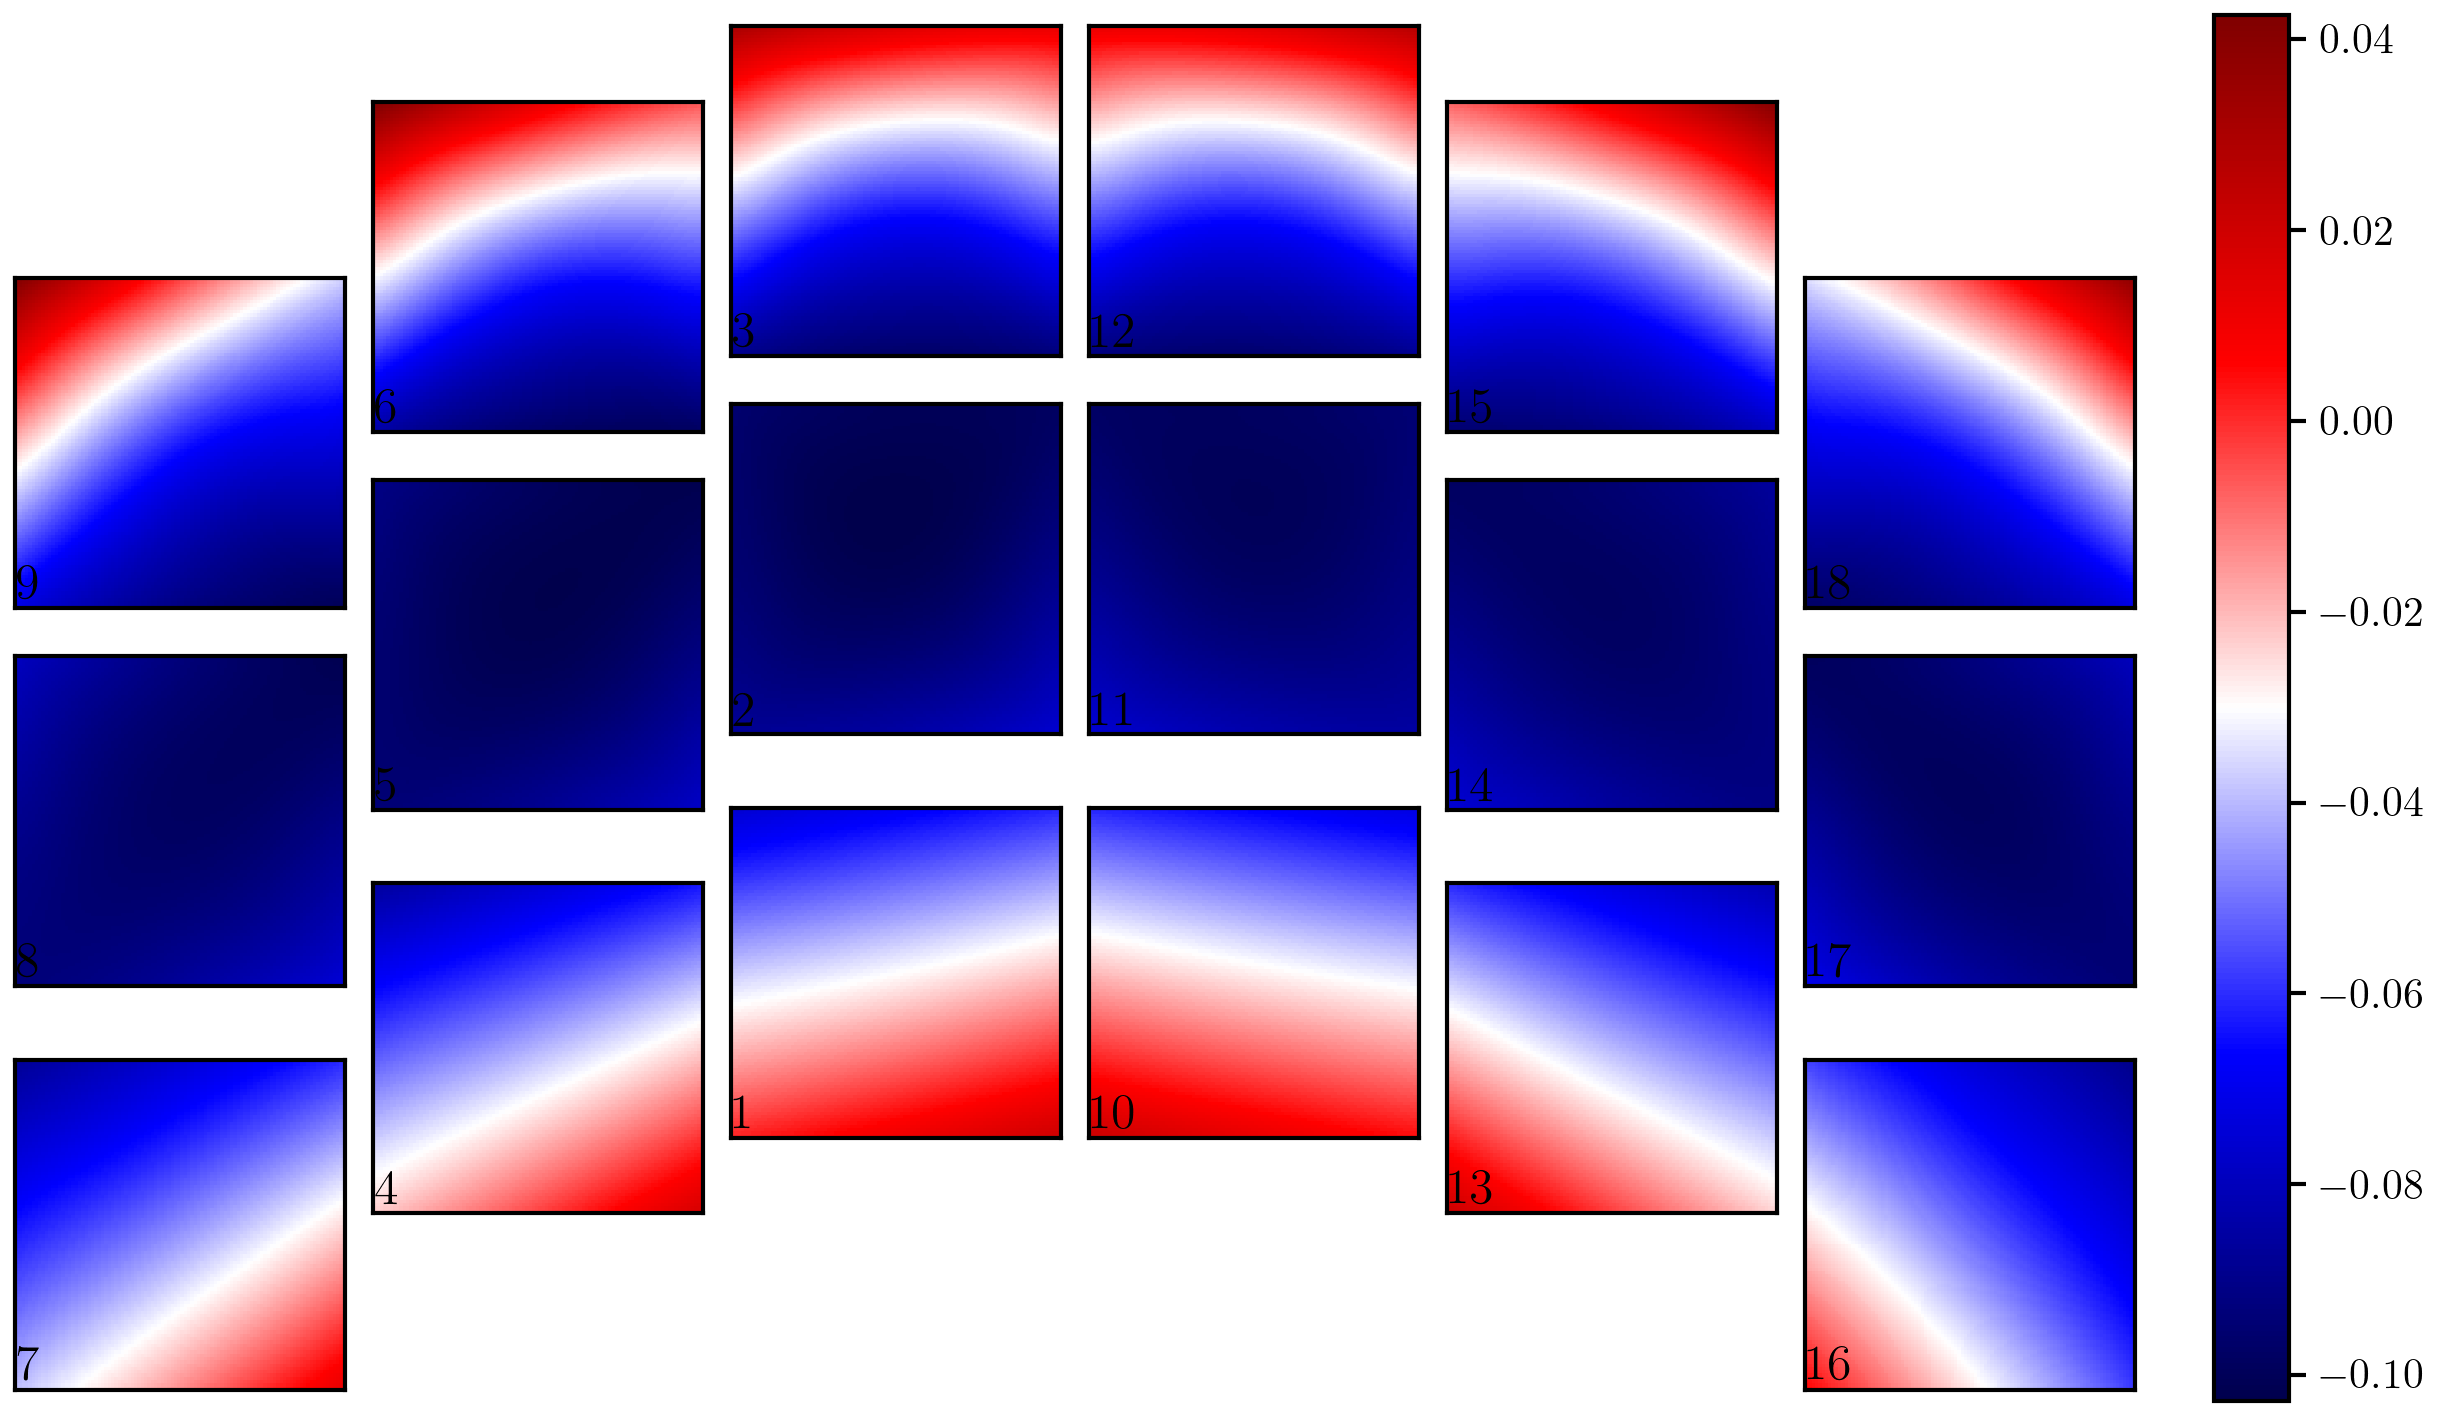

In [10]:
from phrosty import plotting

plotting.roman_sca_plot(np.asarray(arrays), np.asarray(range(1, 19)), residual_plot=False, show_sca_id=True,
                        cmap='seismic')